In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
imgs = pd.read_csv('emnist-letters-train.csv')

imgs.head()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
imgs.shape

(99039, 785)

In [50]:
imgs_unlabeled = imgs.iloc[:, 1:].values

labels = imgs.iloc[:, 0].values

In [51]:
num_imgs = imgs_unlabeled.shape[0]
img_size = int(np.sqrt(imgs_unlabeled.shape[1]))  # Assuming square images

In [52]:
imgs = imgs_unlabeled.reshape(num_imgs, img_size, img_size)

imgs = np.array([np.rot90(np.flipud(img), k=3) for img in imgs])

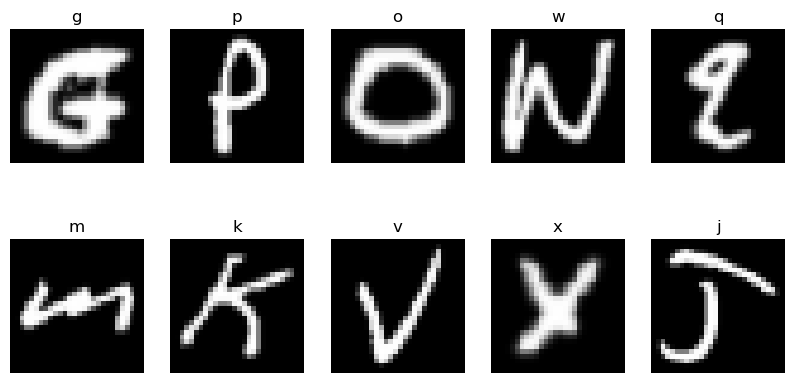

In [53]:
num_plot = 10
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < num_plot:
        ax.imshow(imgs[i], cmap='gray')
        ax.set_title(chr(labels[i] + 96))
        ax.axis('off')

plt.show()

In [54]:
class_images = {}
for label in np.unique(labels):
    class_images[label] = imgs[labels == label]

num_classes = len(class_images)

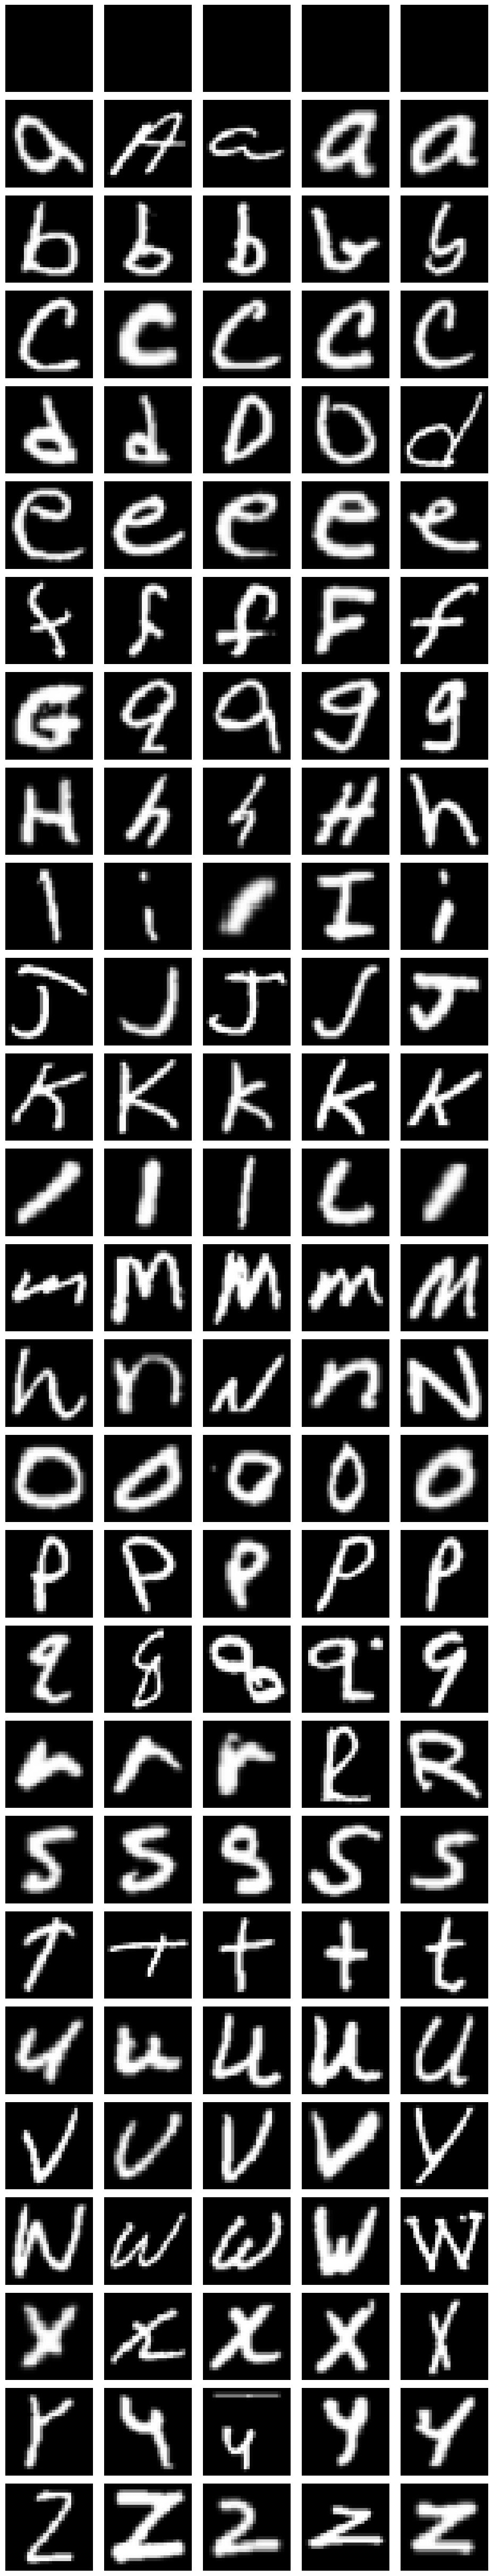

In [55]:
num_plot = 5

fig, axes = plt.subplots(num_classes, num_plot, figsize=(num_plot * 2, num_classes * 2))

for i, (label, imgs) in enumerate(class_images.items()):
    for j in range(num_plot):
        if j < len(imgs):
            axes[i, j].imshow(imgs[j], cmap='gray')
            axes[i, j].axis('off')
    # Add class labels to the left of the row
    axes[i, 0].set_ylabel(f'Class {label}', rotation=0, labelpad=40, va='center')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()